In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sedpy.observate import load_filters, getSED
import astropy.stats
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import astropy.io.fits as fits
from astropy.modeling import models, fitting
from scipy.signal import medfilt
import scipy
from lmfit.models import GaussianModel, SkewedGaussianModel
import matplotlib.lines as mlines

import os, shutil

#from palettable.tableau import Tableau_10
#col = Tableau_10.hex_colors

#from binotools import calbino
import binotools as bt
import CalBino as cb


plt.style.use('seaborn-talk')
from matplotlib import rc_file
#rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

plt.rc('figure', dpi=150, figsize=(12,5))

# Binospec Telluric Correction and Flux Calibration

Flux calibration code from Ben Johnson, telluric correction by `molecfit`

Run `molecfit` in `os.environ['WORK_DIR']+'/Observing/Binospec/telluric_corrections'`

Save calib files in `os.environ['BINO_DIR']+'2649_BLAS_1/calib/'`

In [3]:
#calib_dir = os.environ['BINO_DIR']+'2649_BLAS_1/calib/'

# Work on sky-subtracted data?
sky_sub = False
if sky_sub:
    skysub_lab = '_skysub'
    flux_scale = 1.
else:
    skysub_lab = ''
    flux_scale = 1.e-19

In [4]:
# Find stars on the mask

# Find the stars
datadir    = "/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/Expositions/"

def find_data():
    """
    Finds raw data
    """
    datadir    = "/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/Expositions/"
    files=sorted(bt.insensitive_glob(datadir+'/*/obj_clean*abs_slits_lin.fits'))
    errs=sorted(bt.insensitive_glob(datadir+'/*/obj_clean*abs_err_slits_lin.fits'))
    return files,errs

spec2D_all,err2D_all = find_data()


stars={}
stars["index"]=[]
stars["id"]=[]
stars["ra"]=[]
stars["dec"]=[]
for ss,f in enumerate( [name for name in fits.open(spec2D_all[0]) if "ImageHDU" in str(name)]): #Get stars index
    #print(name)
    if "f_" in f.header["SLITOBJ"]:
        stars["index"].append(ss)
        stars["id"].append(f.header["SLITOBJ"])
        stars["ra"].append(f.header["ra"])
        stars["dec"].append(f.header["dec"])


for ss,f in enumerate( [name for name in fits.open(spec2D_all[70]) if "ImageHDU" in str(name)]): #Get stars index
    #print(name)
    if "f_" in f.header["SLITOBJ"]:
        stars["index"].append(ss)
        stars["id"].append(f.header["SLITOBJ"])
        stars["ra"].append(f.header["ra"])
        stars["dec"].append(f.header["dec"])

for ss,f in enumerate( [name for name in fits.open(spec2D_all[130]) if "ImageHDU" in str(name)]): #Get stars index
    #print(name)
    if "f_" in f.header["SLITOBJ"]:
        stars["index"].append(ss)
        stars["id"].append(f.header["SLITOBJ"])
        stars["ra"].append(f.header["ra"])
        stars["dec"].append(f.header["dec"])

print(stars)

{'index': [70, 72, 85, 87, 150, 152], 'id': ['f_3', 'f_2', 'f_1', 'f_0', 'f_1', 'f_0'], 'ra': [188.910191, 188.902346, 189.462416, 189.453601, 189.462416, 189.453601], 'dec': [62.352588, 62.363999, 62.363585, 62.369844, 62.363585, 62.369844]}


# Telluric Functions


In [14]:
from astropy.stats import sigma_clip

def giveMaskTelluric(wave_nm):

    telluric_regions = {'O2 A band':[757., 775.],
                        'O2 B-band':[685., 694.]}

    mask_telluric = np.array([], dtype=int)
    for region in telluric_regions:
        mask_telluric = np.hstack((mask_telluric, (np.where((wave_nm > telluric_regions[region][0]) & (wave_nm < telluric_regions[region][1]))[0])))

    return mask_telluric

def std_telluric_region(args, opt_args):
    """RMS of corrected flux in region of O2 A-band"""
    
    alpha, beta = args    
    wave, flux_in, trans_std = opt_args

    mask_telluric=giveMaskTelluric(wave/10.0)
    
    flux_corr = telluric_correction(wave, flux_in, trans_std, alpha, beta)
    plt.plot(wave[mask_telluric],flux_corr[mask_telluric])
    plt.title(str(alpha)+"  "+ str(beta)+"  "+str(np.nanstd(flux_corr[mask_telluric])))
    plt.show()
    return np.nanstd(flux_corr[mask_telluric])

def scaled_transmission(wave, trans_std, alpha=0., beta=1.):
    """
    Translate and scale transmission
    """
    transmission_function = np.interp(wave-alpha, wave, trans_std)**beta   
    return transmission_function

def telluric_correction(wave, flux_in, trans_std, alpha=0., beta=1.):
    """
    Telluric correction (assuming std at same airmass as target)
    
    F_corr = F_in / T(lambda - alpha)**beta
    """
    
    # Translate and scale transmission
    transmission_function = scaled_transmission(wave, trans_std, alpha, beta) 
        
    #flux_out = flux_in/transmission_function
    #flux_out[flux_out == 0.] = np.nan
    
    return transmission_function

def optimized_tellcorr(wave, flux_in, trans_std, verbose=False):
    initial_guess = [0., 1.]  # initial guess can be anything
    result = scipy.optimize.minimize(std_telluric_region, initial_guess, 
                                     args=[wave, flux_in, trans_std])
    if verbose:
        print(result.x)
        
    alpha = result.x[0]
    beta  = result.x[1]
    
    return telluric_correction(wave, flux_in, trans_std, alpha=alpha, beta=beta), alpha, beta


####
# Gonzalo Code
####

def obtainTransmission(wave,fluxSpec,fluxTemplate):
    transm=[ fluxTemplate[i]/fluxSpec[i] for i in range(0,len(wave))]
    #transm=transm/np.median(transm)
    return transm

def TelluricMask(tellCalib,wave):
    wave=np.array(wave)
    tellCalib=np.array(tellCalib)
    wave_nm=wave/10
    telluric_regions = {'O2 A band':[757., 775.],
                    'O2 B-band':[685., 694.]}
    mask_telluric=[]
    for ss,region in enumerate(telluric_regions):
        mask_telluric.append((wave_nm < telluric_regions[region][0]) | (wave_nm > telluric_regions[region][1]))
    mask    =   np.logical_and(*mask_telluric)
    #tellCalibs= np.interp(wave,wave[mask],tellCalib[mask])

    return wave[mask],tellCalib[mask]

def runCalbino(ra,dec,data_wave,data_flux,data_err):
    calbinoStar = cb.FluxCalBino(filter_set=["sdss_g0", "sdss_r0", "sdss_i0"])
    star_mags=calbinoStar.get_star_mags(ra,dec,verbose=False)

    libwave, libflux, libparams = calbinoStar.get_library()
    best_model = calbinoStar.choose_model(star_mags, nmod=1)

    best_sed = getSED(calbinoStar.libwave, best_model, calbinoStar.filters)
    dm       = np.mean(star_mags - best_sed, axis=-1)
    conv     = np.atleast_1d(10**(-0.4 * dm))
    fluxed_model = best_model * conv[:, None]
    
    z = 0.0 # redshift of the star, if known.
    a = (1 + z)
    fluxed_model_interp = np.interp(data_wave, libwave * a, fluxed_model[0])

    #get both into the scale of the sdss magnitudes
    i0=star_mags[2] #only filter in our range 
    filteri0=load_filters(["sdss_i0"])


    waveModel,maskedModel   =   TelluricMask(fluxed_model[0],calbinoStar.libwave)
    waveData,maskedData   =   TelluricMask(data_flux,data_wave)  
    maskedData=zero_to_median(maskedData)

    magModel= getSED(waveModel,maskedModel,filteri0)
    magData=  getSED(waveData,maskedData,filteri0)

    calibModel=mag2flux_dif(i0,magModel)
    calibData=mag2flux_dif(i0,magData)


    fluxed_model_interp= fluxed_model_interp*calibModel
    data_flux*=calibData
    data_err*=calibData

    ##Fit curve to continuum of data and continuum of model, then subtract

    fluxModel_noContinuum=(fluxed_model_interp/calbinoStar.smooth_calibration(data_wave,fluxed_model_interp,degree=2))
    fluxData_noContinuum=(data_flux/calbinoStar.smooth_calibration(data_wave,zero_to_nan(data_flux),degree=2))

    """

    plt.plot(data_wave,fluxed_model_interp)
    #plt.plot(data_wave,medfilt(fluxed_model_interp, 251),alpha=0.8,lw=0.8,ls="--")
    plt.plot(data_wave,calbinoStar.smooth_calibration(data_wave,fluxed_model_interp,degree=2)) 
    plt.show()

    #plt.plot(data_wave,fluxed_model_interp/medfilt(fluxed_model_interp, 251))
    plt.plot(data_wave,fluxed_model_interp/calbinoStar.smooth_calibration(data_wave,fluxed_model_interp,degree=2),alpha=0.6) 
    plt.show()

    plt.plot(data_wave,zero_to_median(data_flux))
    #plt.plot(data_wave,medfilt(data_flux, 501),alpha=0.8,lw=0.8,ls="--") 
    plt.plot(data_wave,calbinoStar.smooth_calibration(data_wave,zero_to_nan(data_flux),degree=2))
    plt.show()

    plt.plot(data_wave,zero_to_median(data_flux)/medfilt(data_flux, 501))
    plt.show()


    #fluxModel_noContinuum=(fluxed_model_interp/medfilt(fluxed_model_interp, 251))
    #fluxData_noContinuum=(data_flux/medfilt(data_flux, 501))

    plt.plot(data_wave,fluxData_noContinuum/fluxModel_noContinuum)
    plt.axhline(y=1,ls="--",alpha=0.9,color="black")
    plt.ylim(-0.5,1.5)
    plt.show()

    """
    #calibration =  data_flux   /fluxed_model_interp
    calibration =   fluxData_noContinuum/fluxModel_noContinuum   




    calibration=[ 1.0 if c>1.0 else c for c in calibration]
  

    smoothed_calibration = medfilt(calibration, 101)
    
    calibration=zero_to_median(calibration)
    calibration,smoothed_calibration=zero_to_one(calibration),zero_to_one(smoothed_calibration)
    

    return fluxed_model_interp,calibration,smoothed_calibration



# Fitting Functions

In [6]:
# 1D slit spectra

from scipy.optimize import minimize
from scipy import interpolate
import os

def gaussian_ML(x,flux, mu, sig,C) :
    """Gaussian"""
    return flux* np.exp( -0.5 * (x-mu)**2 / sig**2) + C

def log_likelihood_ML(theta, x, y, yerr):
    flux, mu,sig,C = theta
    model = gaussian_ML(x,flux, mu,sig,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def obtainSeeing(data,reps,rango):
    seeings=[]
    for i in range(0,reps-5):
        sectionData = data[:,interval*i:interval*(i+1)] #Cut section of the data 
        collapsedData = np.nansum(sectionData,axis=1)
        collapsedData=collapsedData/np.max(collapsedData)
        #print(collapsedData)

        waveX=range(0,len(collapsedData))
        nll = lambda *args: -log_likelihood_ML(*args)   #ML fit
        initial = np.array([1,rango,1,0 ])
        soln = minimize(nll, initial, args=(waveX, collapsedData, np.sqrt(collapsedData+0.01)))
        flux,mu,sig,C = soln.x
        
        fwhm=2.355*sig
        seeings.append(fwhm)
        #plt.plot(np.linspace(0,len(collapsedData),500),gaussian_ML(np.linspace(0,len(collapsedData),500),*soln.x))
        #plt.plot(waveX,collapsedData)
        #plt.axvline(x=mu+fwhm)
        #plt.axvline(x=mu-fwhm)
        #plt.show()
    return np.nanmedian(seeings)


# Conversion Functions

In [7]:
def interpolateStar(wave,flux):
    f = interpolate.interp1d(wave, flux)
    return f

def ABtoFlux(AB):
    flux=10**-((AB+48.6)/2.5)
    return flux

def mag2flux_dif(observation,data):
    fluxCalib=ABtoFlux(observation)/ABtoFlux(data)
    return fluxCalib

def zero_to_median(lista):
    smoothed=medfilt(lista, 101)
    for i in range(0,len(lista)):
        if lista[i]==0:
            lista[i]=smoothed[i]
    return lista

def zero_to_nan(lista):
    for i in range(0,len(lista)):
        if lista[i]==0:
            lista[i]=np.nan
    return lista

def zero_to_one(lista):
    for i in range(0,len(lista)):
        if lista[i]==0:
            lista[i]=1
    return lista

# Flux Calibration Functions

In [8]:
def FluxCalib(ra,dec,data_wave,data_flux):
    #Flux must be already telluric calibrated
    calbinoStar = cb.FluxCalBino(filter_set=["sdss_g0", "sdss_r0", "sdss_i0"])
    star_mags=calbinoStar.get_star_mags(ra,dec,verbose=False)
    i0=star_mags[2] #only filter in our range 

    filteri0=load_filters(["sdss_i0"])
    magData=  getSED(data_wave, np.nan_to_num(data_flux,posinf=np.nanmedian(data_flux),neginf=np.nanmedian(data_flux)),filteri0)
    calibData=mag2flux_dif(i0,magData)

    return calibData

## Main


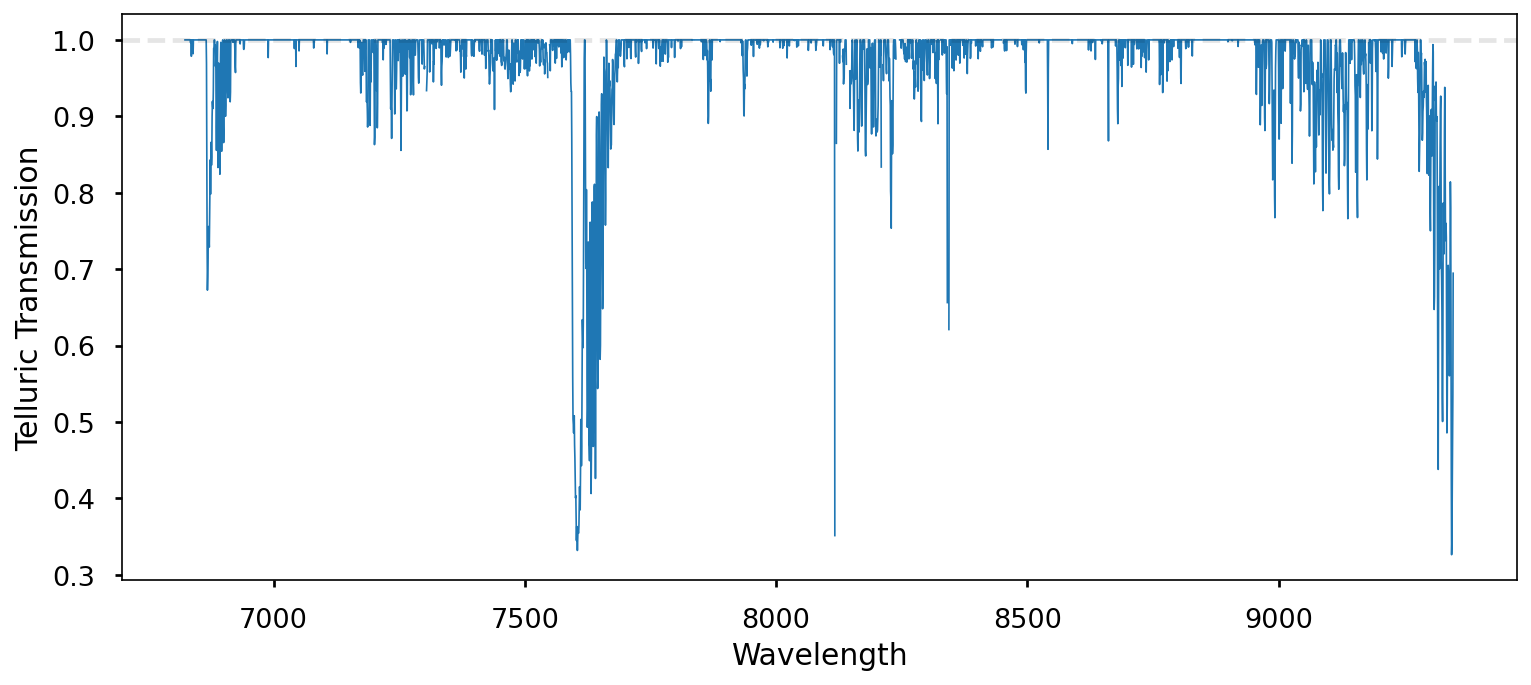

(0.09601126650051106, -5.109322742669065e-09)


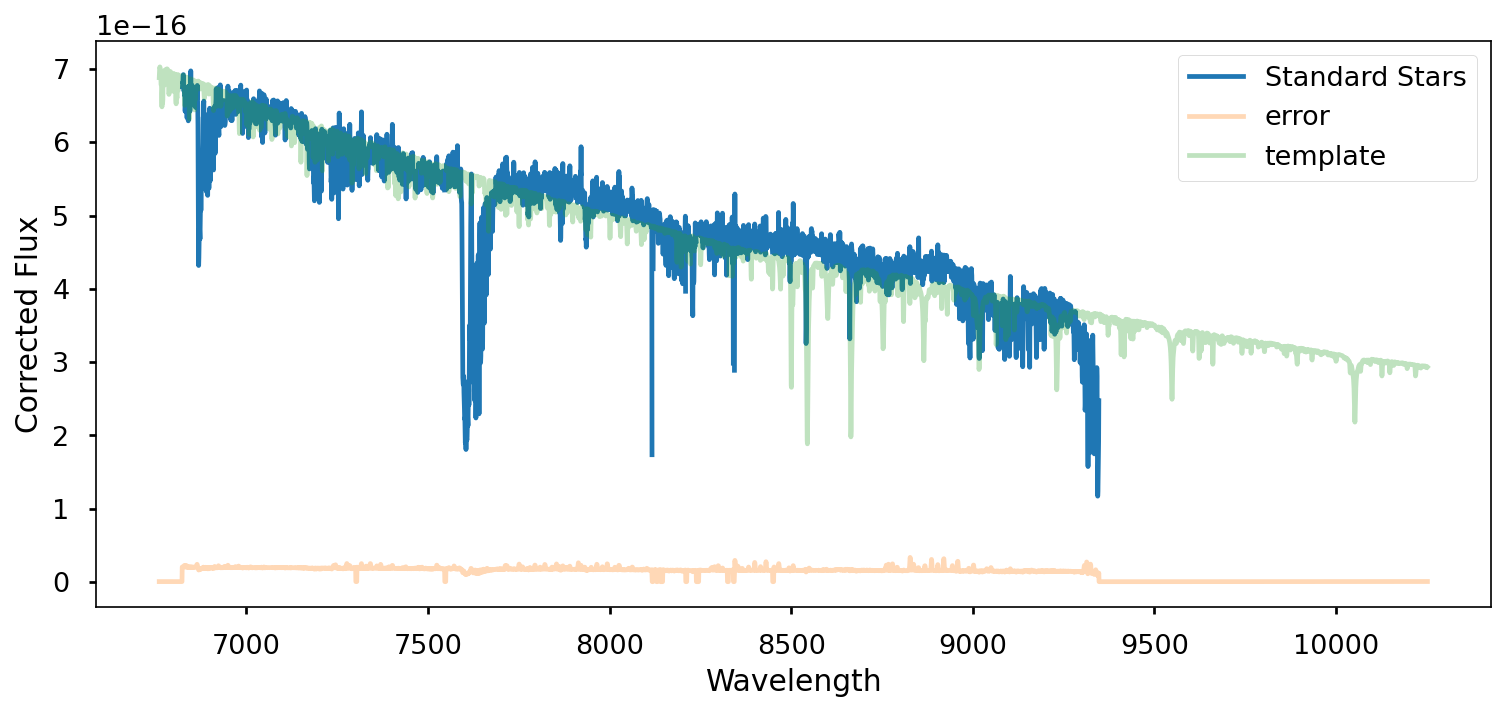

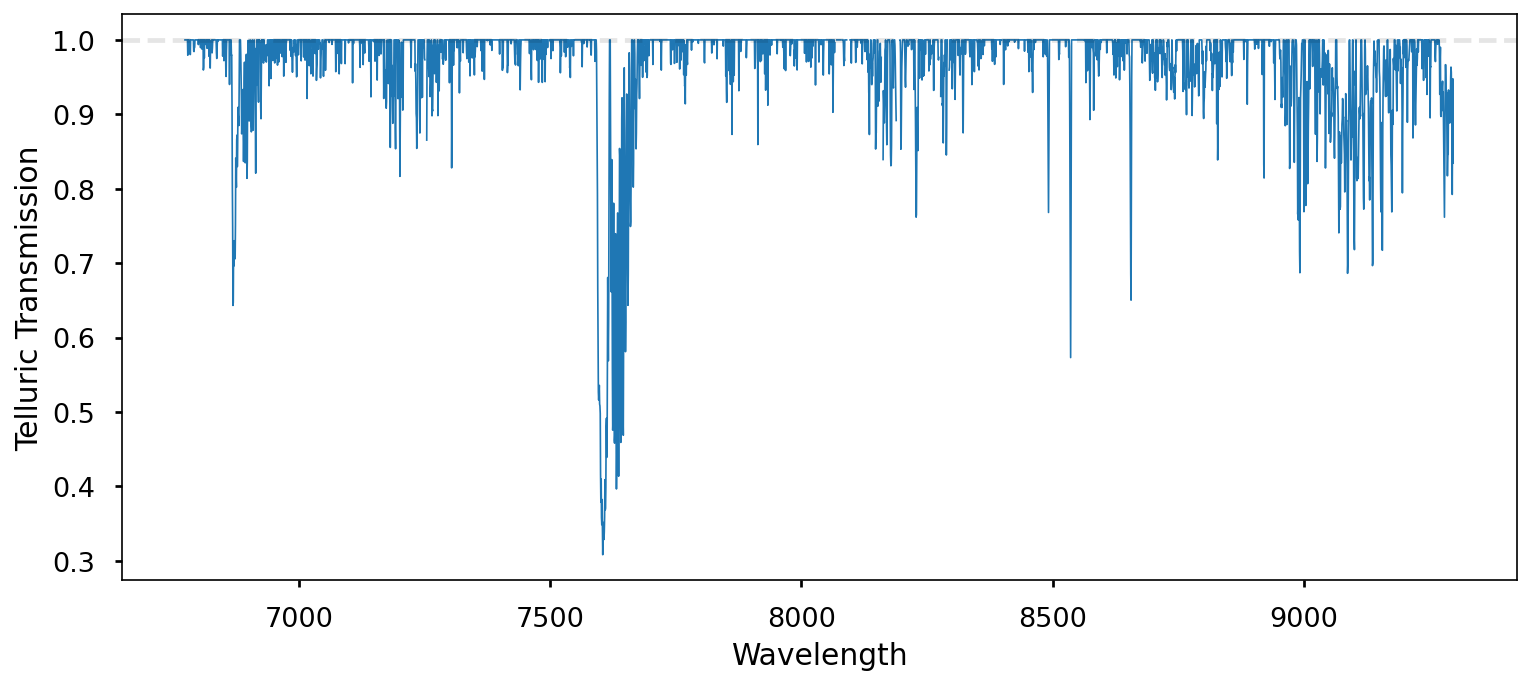

(0.1209588402524867, -4.756007365713799e-09)


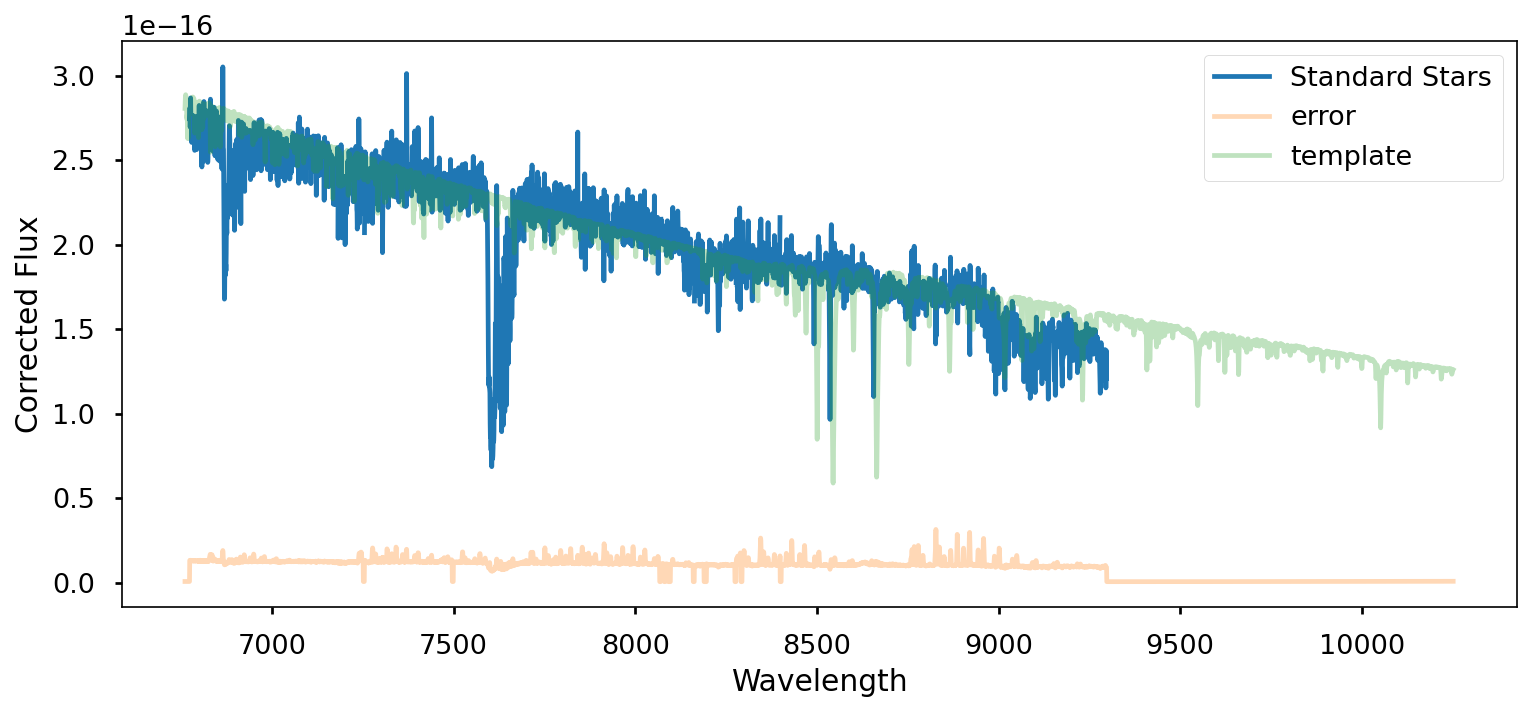

'\n    wave=wave\n    tCalibration=np.nanmedian(tCalibration,axis=0)\n    fCalibration=np.nanmedian(fCalibration)\n\n    for ss,ext in enumerate(gal[1:]):\n\n        ext.data=ext.data/(tCalibration)*fCalibration*1e-17\n    \n    print(f.split(".fits")[0]+"_fluxcal_telcor.fits")\n    ordir=f.split(".fits")[0]+"_fluxcal_telcor.fits"\n\n\n\n    newdir="/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/Expositions/"+folder+"/"+ordir.split("/")[-2]\n    isExist = os.path.exists(newdir)\n    if not isExist:\n        # Create a new directory because it does not exist \n        os.makedirs(newdir)\n        print("The new directory is created!")\n\n\n\n    print(newdir)\n    gal.writeto(newdir+"/"+ordir.split("/")[-1],overwrite=True)\n\n    for ss,ext in enumerate(errgal[1:]):\n\n        ext.data=ext.data/(tCalibration)*fCalibration*1e-17\n    \n    print(err2D_all[ii].split(".fits")[0]+"_fluxcal_telcor.fits")\n    ordir=err2D_all[ii].split(".fits")[0]+"_fluxcal_telco

In [15]:


PSF,PSF_ALL=[],[]
FCAL,FCAL_ALL=[],[]
for ii,f in enumerate(spec2D_all[:1]):
    gal=fits.open(f)
    errgal=fits.open(err2D_all[ii])
    tCalibration=[]
    fCalibration=[]
    PSFs=[]
    FCALs=[]

    folder=""

    if len(gal)==171:
        starIdx=stars['index'][:2]
        folder='mask2_1'
    if len(gal)==152:
        starIdx=stars['index'][2:4]
        folder="mask2_2"
    if len(gal)==154:
        starIdx=stars['index'][4:6]
        folder="mask2_3"


    for n in starIdx:
        n=n+1 # to ignore first element in each .fits
        Obj,errObj=gal[n],errgal[n]
        Yposition=int(np.round(Obj.header["SLITYPIX"]))
        rng = 15 
        if rng>=Yposition:
            rng=Yposition
        dat=Obj.data[Yposition-rng:Yposition+rng]
        err=errObj.data[Yposition-rng:Yposition+rng]
        repetitions=20
        interval=int(np.shape(dat)[1]/repetitions)
        # CALCULATE SEEING FOR EACH STAR IN EACH EXPOSURE
        seeing=obtainSeeing(dat,repetitions,rng)
        PSFs.append(seeing)
        
        starSpec=Obj.data[Yposition-int(np.round(seeing)): Yposition+int(np.round(seeing))]
        starSpec=np.nansum(starSpec,axis=0)
        starSpecerr=errObj.data[Yposition-int(np.round(seeing)): Yposition+int(np.round(seeing))]
        starSpecerr=np.nansum(starSpecerr,axis=0)
        # header units are 1e-17 erg/s/cm^2/AA
        starSpec*=1e-17
        starSpecerr*=1e-17

        nstep   = len(starSpec)
        wave_nm = (Obj.header['CRVAL1'] + np.linspace(0., nstep*Obj.header['CDELT1'], nstep))
        wave=wave_nm*10


        template,noisyCalib,tellCalib=   runCalbino(Obj.header['ra'] ,Obj.header['dec'],wave,starSpec,starSpecerr)

        
        #plt.plot(wave,starSpec,label='Standard Stars')
        #plt.plot(wave,starSpecerr,alpha=0.3,label='error')
        #plt.plot(wave,fluxTemplate,label="template")
        #plt.legend()
        #plt.show()
        #transmission =  obtainTransmission(wave,starSpec,fluxTemplate)

        #plt.plot(wave,transmission,lw=0.3)
        #wave,tellCalib   =   TelluricMask(tellCalib,wave)
        #wave,noisyCalib   =   TelluricMask(noisyCalib,wave)   
        #print(np.median(tellCalib))

        plt.plot(wave,noisyCalib,lw=0.8)
        #plt.plot(wave,tellCalib,lw=0.8)
        plt.axhline(y=1,alpha=0.1,ls="--",color="black")
        plt.xlabel("Wavelength")
        plt.ylabel("Telluric Transmission")
#        plt.savefig("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/CalibFigs/"+str(ii)+"_star"+str(n)+"_tellcor.pdf")
#        plt.close()
        plt.show()


        tellCalib=np.nan_to_num(noisyCalib,nan=1.0,posinf=1.0,neginf=1.0) #####USE NON-SMOOTH CALIBRATION

        optimisedTellCalib=optimized_tellcorr(wave,starSpec,tellCalib)
        print(optimisedTellCalib[1:])
        
        
        #plt.plot(wave,optimisedTellCalib[0])
        #plt.show()

        tellCalib=optimisedTellCalib[0]


        fluxCal=FluxCalib(Obj.header['ra'] ,Obj.header['dec'],wave,starSpec*tellCalib)
        tCalibration.append(tellCalib)
        fCalibration.append(fluxCal)
        FCALs.append(fluxCal[0])
        #print(FCALs)

        plt.plot(wave,starSpec/tellCalib*fluxCal,label='Standard Stars')
        plt.plot(wave,starSpecerr/tellCalib*fluxCal,alpha=0.3,label='error')
        plt.plot(wave,template*fluxCal,label="template",alpha=0.3)
        plt.xlabel("Wavelength")
        plt.ylabel("Corrected Flux")
        plt.legend()
        plt.show()
#        plt.savefig("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/CalibFigs/"+str(ii)+"_star"+str(n)+"_fluxcal.pdf")
#        plt.close()
    PSF.append(np.median(PSFs))
    FCAL.append(np.median(FCALs))

    PSF_ALL.append(PSFs)
    FCAL_ALL.append(FCALs)
    #print(FCAL_ALL)

     
"""
    wave=wave
    tCalibration=np.nanmedian(tCalibration,axis=0)
    fCalibration=np.nanmedian(fCalibration)

    for ss,ext in enumerate(gal[1:]):

        ext.data=ext.data/(tCalibration)*fCalibration*1e-17
    
    print(f.split(".fits")[0]+"_fluxcal_telcor.fits")
    ordir=f.split(".fits")[0]+"_fluxcal_telcor.fits"



    newdir="/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/Expositions/"+folder+"/"+ordir.split("/")[-2]
    isExist = os.path.exists(newdir)
    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(newdir)
        print("The new directory is created!")



    print(newdir)
    gal.writeto(newdir+"/"+ordir.split("/")[-1],overwrite=True)

    for ss,ext in enumerate(errgal[1:]):

        ext.data=ext.data/(tCalibration)*fCalibration*1e-17
    
    print(err2D_all[ii].split(".fits")[0]+"_fluxcal_telcor.fits")
    ordir=err2D_all[ii].split(".fits")[0]+"_fluxcal_telcor.fits"
    newdir="/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/data/large_files/Raw/mask2/Expositions/"+folder+"/"+ordir.split("/")[-2]
    print(newdir)
    errgal.writeto(newdir+"/"+ordir.split("/")[-1],overwrite=True)


"""







        

#nstep   = spec1D.shape[1]
#wave_nm = header['CRVAL1'] + np.linspace(0., nstep*header['CDELT1'], nstep)
            
        
 





# SEEING and FWHM figures

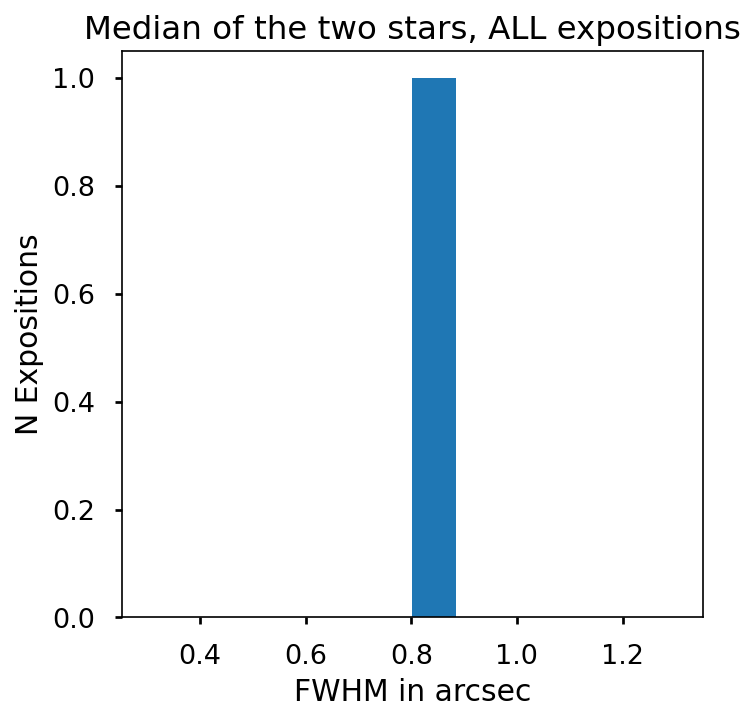

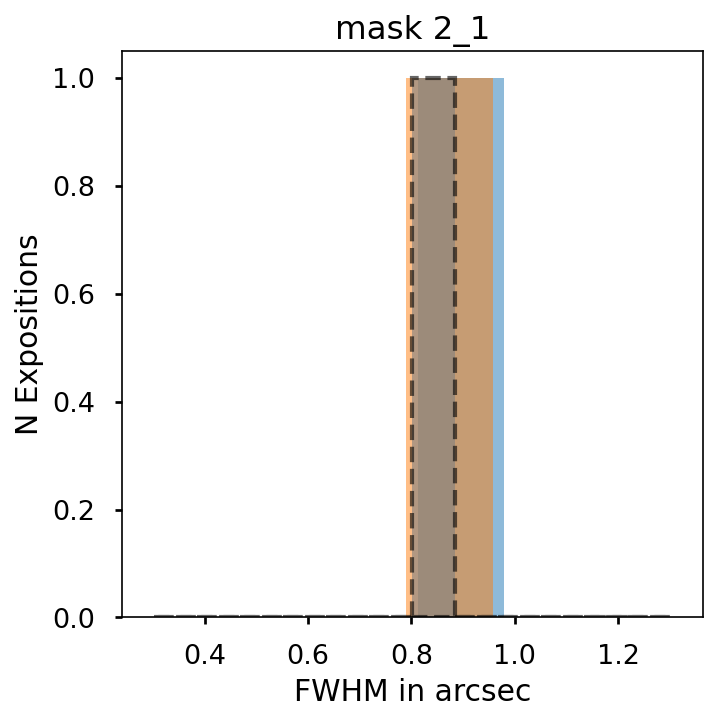

IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
def flatten(t):
    return np.array([item for sublist in t for item in sublist])


pixscale=0.24

plt.hist(np.array(PSF)*pixscale,bins=12)
plt.ylabel("N Expositions")
plt.xlabel("FWHM in arcsec")
plt.title("Median of the two stars, ALL expositions")
plt.show()

cut1,cut2=66,122

plt.hist(np.transpose(PSF_ALL[0:cut1])[0]*pixscale,bins=6,alpha=0.5)
plt.hist(np.transpose(PSF_ALL[0:cut1])[1]*pixscale,bins=6,alpha=0.5)
plt.hist(np.array(PSF[0:cut1])*pixscale,bins=12,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("FWHM in arcsec")
plt.title("mask 2_1")
plt.show()

plt.hist(np.transpose(PSF_ALL[cut1:cut2])[0]*pixscale,bins=3,alpha=0.5)
plt.hist(np.transpose(PSF_ALL[cut1:cut2])[1]*pixscale,bins=3,alpha=0.5)
plt.hist(np.array(PSF[cut1:cut2])*pixscale,bins=12,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("FWHM in arcsec")
plt.title("mask 2_3")
plt.show()

plt.hist(np.transpose(PSF_ALL[cut2:])[0]*pixscale,bins=3,alpha=0.5)
plt.hist(np.transpose(PSF_ALL[cut2:])[1]*pixscale,bins=3,alpha=0.5)
plt.hist(np.array(PSF[cut2:])*pixscale,bins=12,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("FWHM in arcsec")
plt.title("mask 2_3")
plt.show()

plt.hist(FCAL,bins=20)
plt.ylabel("N Expositions")
plt.xlabel("Flux Cal")
plt.title("Median of the two stars, ALL expositions")
plt.show()

plt.hist(np.transpose(FCAL_ALL[0:cut1])[0],bins=5)
plt.hist(np.transpose(FCAL_ALL[0:cut1])[1],bins=5)
plt.hist(np.array(FCAL[0:cut1]),bins=10,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("Flux Cal")
plt.title("mask 2_1")
plt.show()

plt.hist(np.transpose(FCAL_ALL[cut1:cut2])[0],bins=5)
plt.hist(np.transpose(FCAL_ALL[cut1:cut2])[1],bins=5)
plt.hist(np.array(FCAL[cut1:cut2]),bins=10,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("Flux Cal")
plt.title("mask 2_2")
plt.show()

plt.hist(np.transpose(FCAL_ALL[cut2:])[0],bins=5)
plt.hist(np.transpose(FCAL_ALL[cut2:])[1],bins=5)
plt.hist(np.array(FCAL[cut2:]),bins=10,color="gray",ls="--",edgecolor="black",lw=2.0,alpha=0.6)
plt.ylabel("N Expositions")
plt.xlabel("Flux Cal")
plt.title("mask 2_3")
plt.show()


In [10]:
#print(spec2D_all[66:67])
counter=0
first=[]
for n,f in enumerate(spec2D_all[0:1]):
    gal=fits.open(f)
    for i in gal[1:]:
        if "z" in i.header["SLITOBJ"]:
            counter+=1
            first.append(i.header["SLITOBJ"])
            #print(i.header["SLITOBJ"])
print(counter)

second=[]
counter=0
for n,f in enumerate(spec2D_all[70:71]):
    gal=fits.open(f)
    for i in gal[1:]:
        if "z" in i.header["SLITOBJ"]:
            counter+=1
            second.append(i.header["SLITOBJ"])
            #print(i.header["SLITOBJ"])
print(counter)

third=[]
counter=0
for n,f in enumerate(spec2D_all[131:132]):
    gal=fits.open(f)
    for i in gal[1:]:
        if "z" in i.header["SLITOBJ"]:
            counter+=1
            third.append(i.header["SLITOBJ"])
            #print(i.header["SLITOBJ"])
print(counter)

for i in first:
    for j in second:
        if i==j:
            print(i,j)

for i in first:
    for j in third:
        if i==j:
            print(i,j)

for i in second:
    for j in third:
        if i==j:
            print(i,j)

88
74
56


In [43]:
for n,f in enumerate(spec2D_all[0:66]):
    gal=fits.open(f)
    print(n,len(gal))

0 171
1 171
2 171
3 171
4 171
5 171
6 171
7 171
8 171
9 171
10 171
11 171
12 171
13 171
14 171
15 171
16 171
17 171
18 171
19 171
20 171
21 171
22 171
23 171
24 171
25 171
26 171
27 171
28 171
29 171
30 171
31 171
32 171
33 171
34 171
35 171
36 171
37 171
38 171
39 171
40 171
41 171
42 171
43 171
44 171
45 171
46 171
47 171
48 171
49 171
50 171
51 171
52 171
53 171
54 171
55 171
56 171
57 171
58 171
59 171
60 171
61 171
62 171
63 171
64 171
65 171


# Mask bad telluric region of O2 lines

In [20]:
help(load_filters)

Help on function load_filters in module sedpy.observate:

load_filters(filternamelist, **kwargs)
    Given a list of filter names, this method returns a list of Filter
    objects.
    
    :param filternamelist:
        List of strings giving names of the filters.
    
    :returns filterlist:
        A list of filter objects.



No handles with labels found to put in legend.


Text(0, 0.5, 'Transmission')

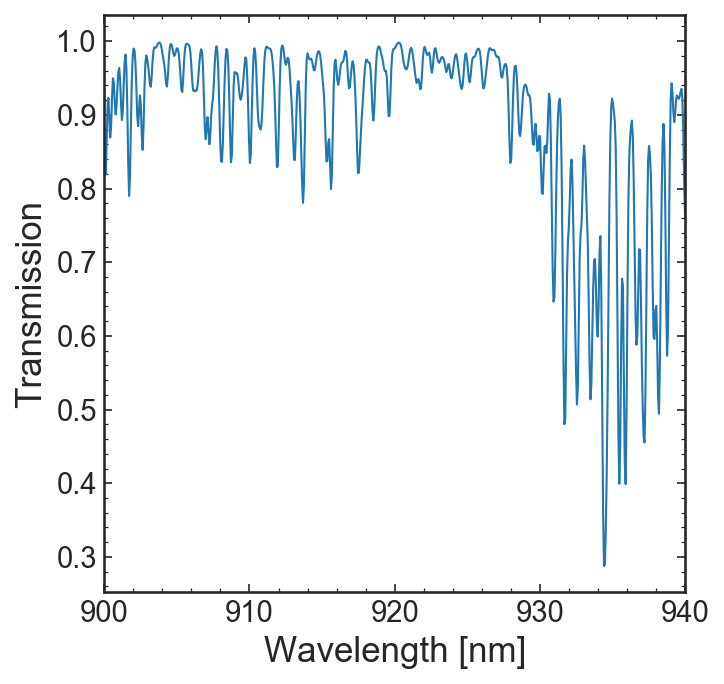

In [60]:
telluric_dir = calib_dir+'telluric_corrections/'

# Load transmission spectrum

### THIS IS WHAT I NEED TO MAKE
trans_std_tab = np.genfromtxt(calib_dir+'BLAS_2019A_transmission.txt', names=True)
trans_std = trans_std_tab['transmission']

plt.plot(trans_std_tab['wave_nm'], trans_std, lw=1)

# plt.xlim(920,924)
plt.xlim(900, 940)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission')

# Plot 1D and 2D bino spectra of stars

## Plot each frame


2019.0208
2019.0212
2019.0329
2019.0331
2019.0404


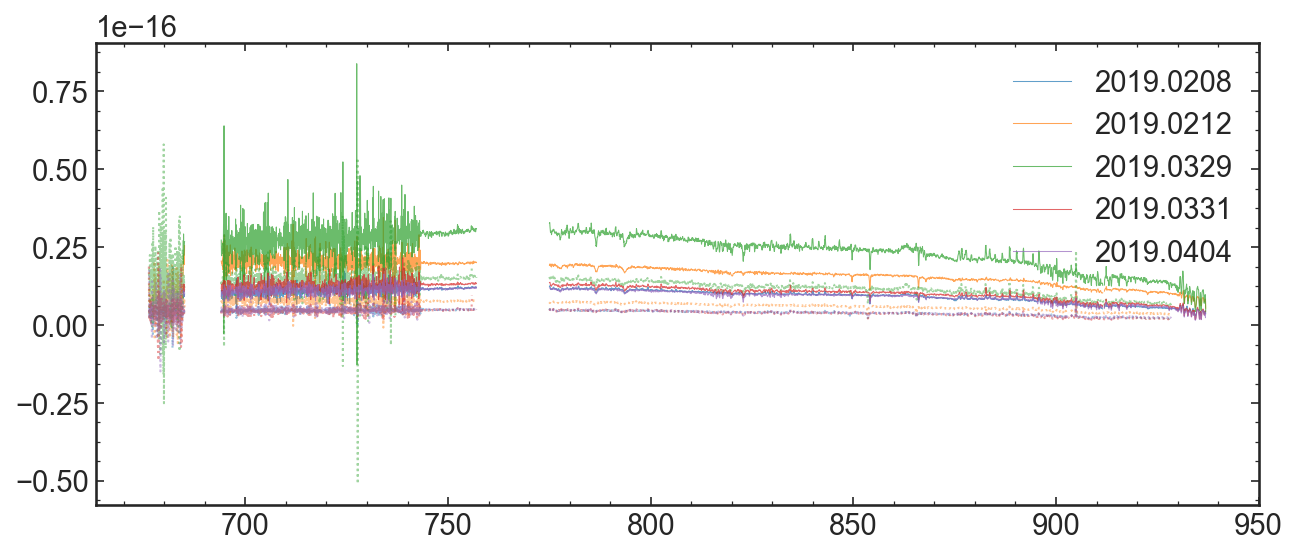

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,4), dpi=150)

linestyle = ['solid', 'dotted']

for ss, spec1D_file in enumerate(spec1D_all):
    
    night = spec1D_file.split('/')[-2]
    print(night)
    
    extract1D  = fits.open(spec1D_file)

    spec1D = extract1D['FLUX'].data
    err1D  = extract1D['ERROR'].data

    for i in range(2):
        
        if i == 1:
            night = None
            
        spec1D_star = spec1D[stars.index[i]]*flux_scale
        err1D_star  = err1D[stars.index[i]]*flux_scale
        spec1D_star[mask_telluric] = np.nan

        # From pipeline
        ax1.plot(wave_nm, spec1D_star, alpha=0.7-i/4, 
                      lw=0.5+i/2, c=col[ss], ls=linestyle[i], label=night)
        
#         ax1.semilogy(wave_nm, err1D_star, alpha=0.3, 
#                  lw=1, c=col[ss])

ax1.legend()

# ax1.set_ylim(0., 4e-17)

# Load a calibrator star and get magnitude from SDSS

In [11]:
def load_star_spec(star_id, mask_pix=20, tell_corr=True, verbose=False):
    """
    Load star, get flux and wavelength, and coords from bino spectrum
    """

    spec1D_mask = spec1D[star_id].copy()
    if tell_corr:
        # Do telluric correction
        spec1D_mask, alpha, beta = optimized_tellcorr(wave_nm, spec1D_mask, trans_std, verbose=verbose)
    else:
        # Mask bad telluric
        spec1D_mask[mask_telluric] = np.nan
        alpha, beta = 0., 1.

    # Mask edges of detector
    if mask_pix == 0: 
        mask_pix = 1
        
    finite_mask = np.where(~np.isnan(spec1D_mask))[0]
    spec1D_mask[finite_mask[:mask_pix]]  = np.nan
    spec1D_mask[finite_mask[-mask_pix:]] = np.nan

    # And here you'd get the bino spectrum for the calibrator star.
    # data_pix, data_wave, data_flux = np.genfromtxt("star.csv", delimiter=",", unpack=True, skip_header=1)
    data_pix, data_wave, data_flux  = np.arange(nstep), wave_nm*10., spec1D_mask.copy()
    
    if sky_sub is False:
        # header units are 1e-19 erg/s/cm^2/AA [if'abs']
        data_flux = flux_scale * data_flux.copy()

    # Get from header slit_ra?
    ra, dec = stars.loc[star_id].ra, stars.loc[star_id].dec
    mag_g, mag_r, mag_i = 23., 23.02, 23.1

    return data_wave, data_flux, ra, dec, alpha, beta

# Estimate star i band flux density from SDSS mags

How does it compare with pipeline flux?

In [12]:
# Init flux cal
fluxcal = calbino.FluxCalBino()

# Do flux calibration and smoothing

## Run for each frame

Not much difference between masking telluric or correcting for it in the flux calibration

2019.0208


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


2019.0212
2019.0329
2019.0331
2019.0404


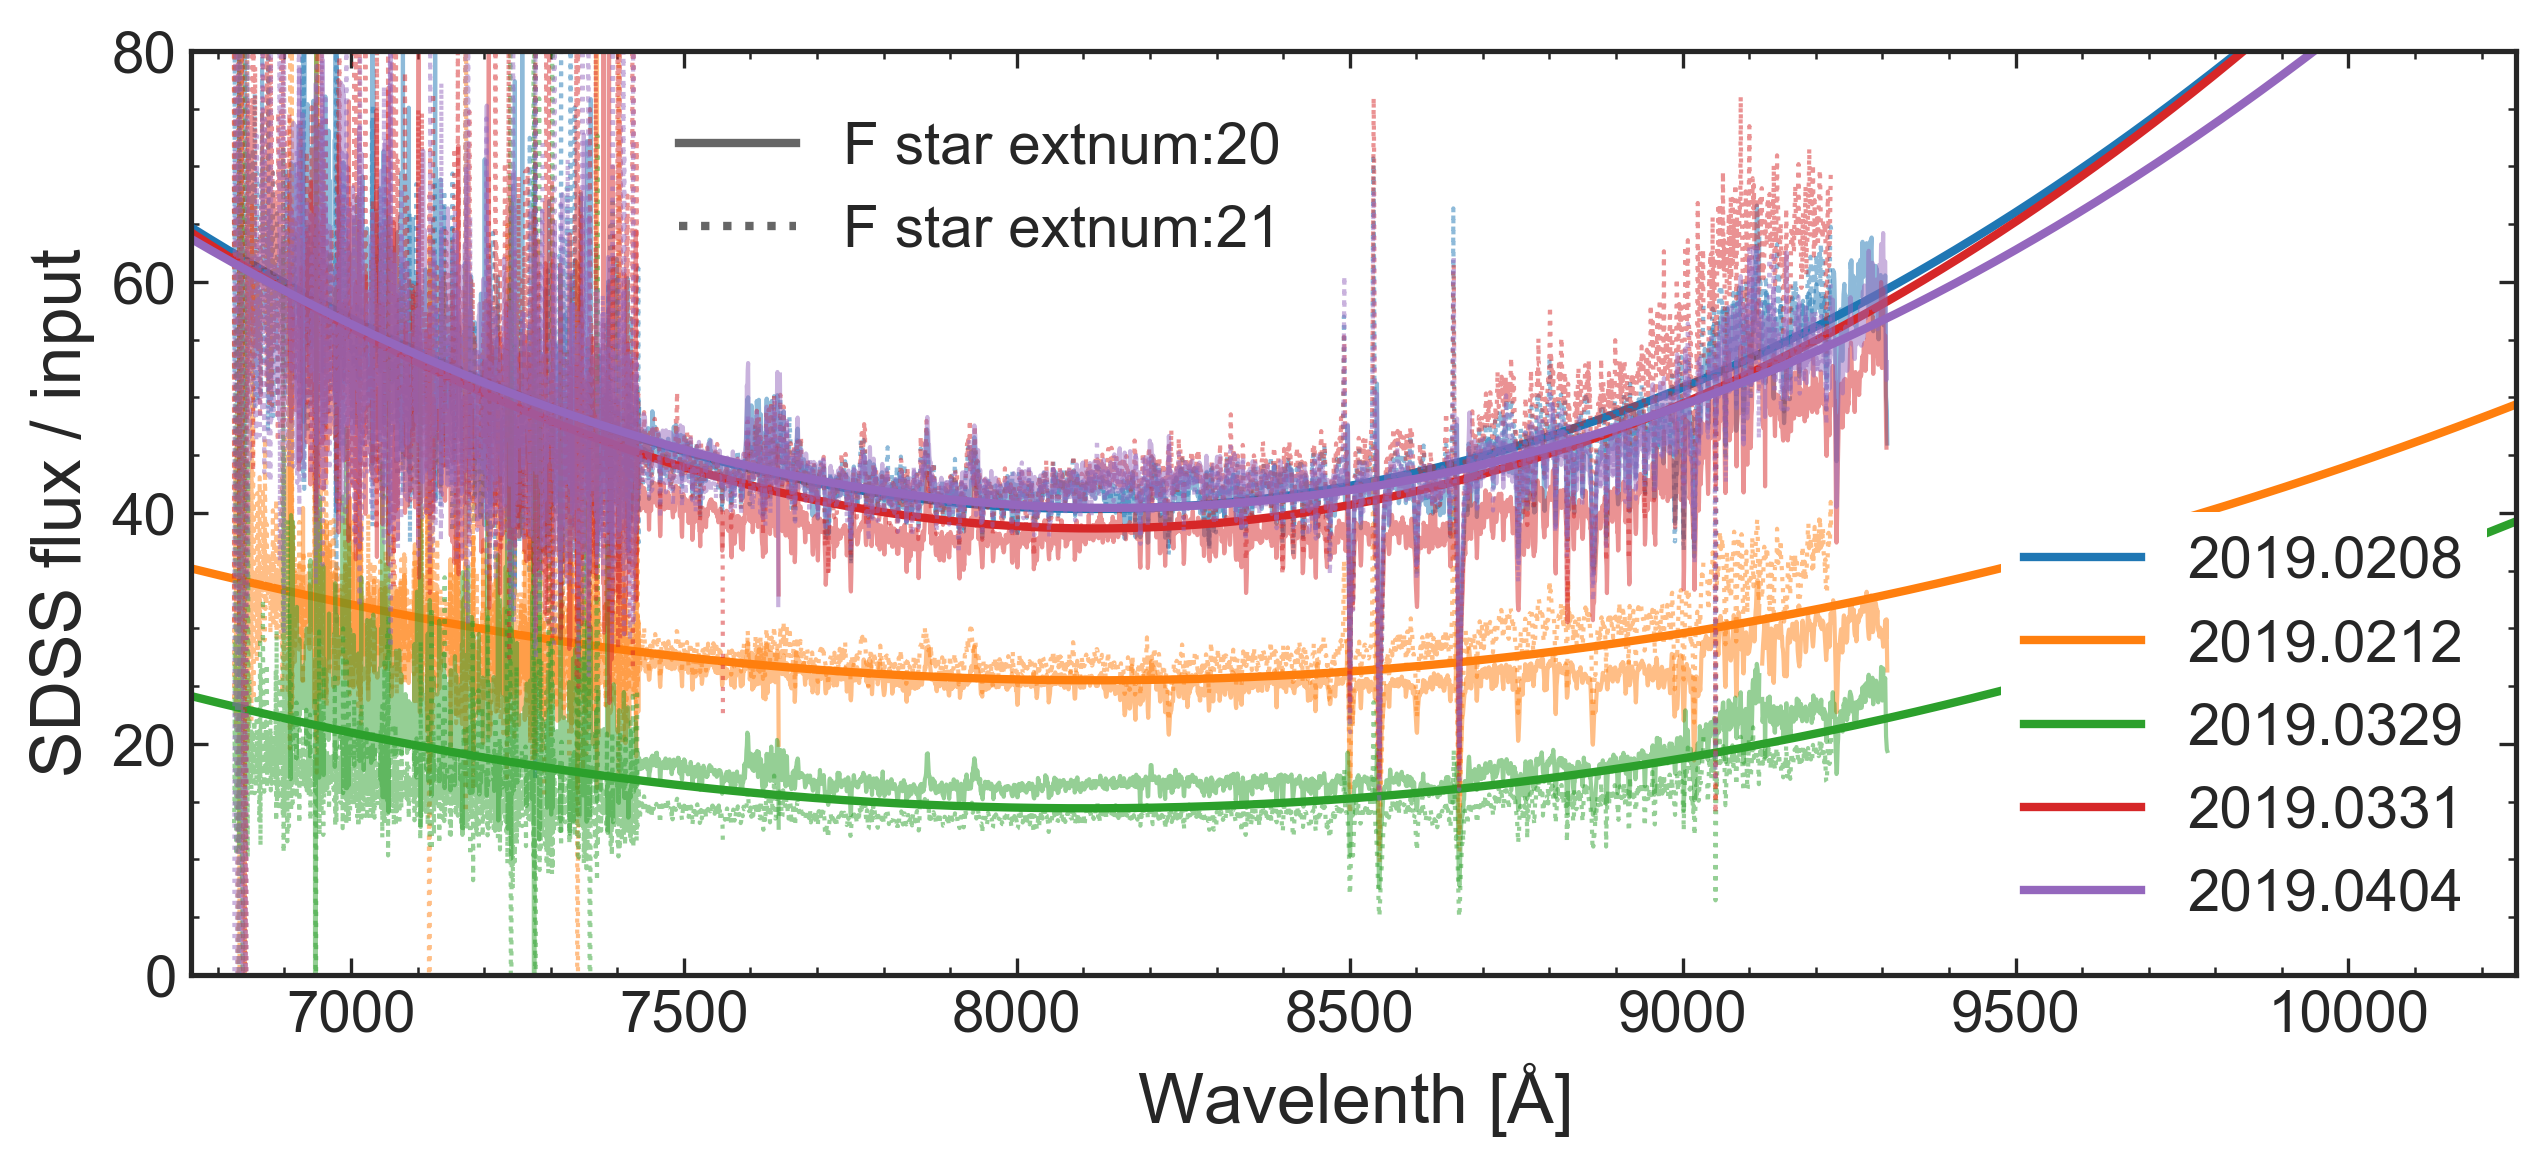

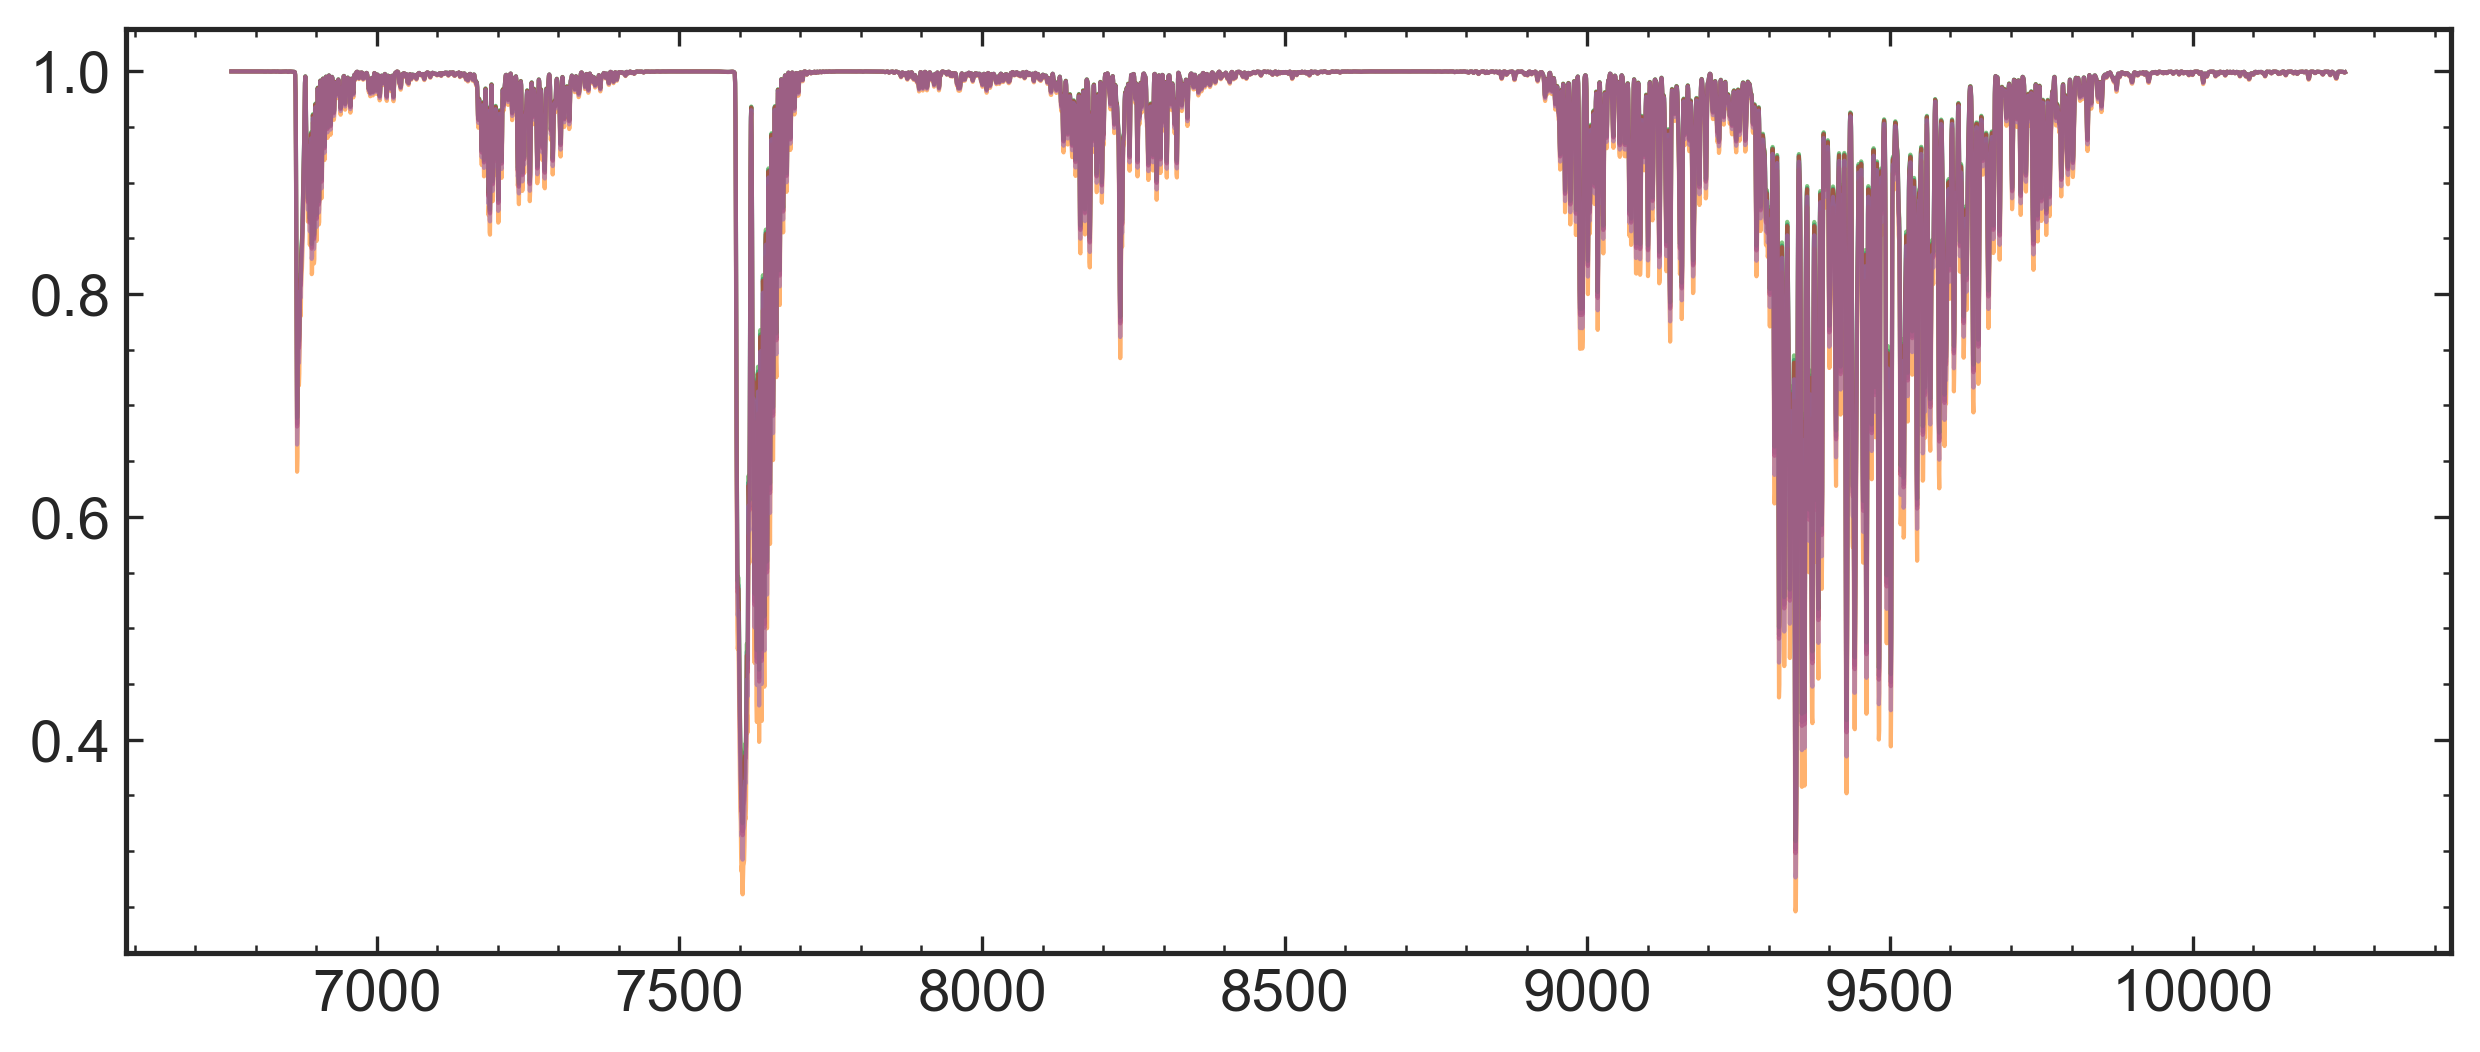

In [13]:
fig1, ax1 = plt.subplots(1,1, figsize=(10,4), dpi=300)
fig2, ax2 = plt.subplots(1,1, figsize=(10,4), dpi=300)

for ss, spec1D_file in enumerate(spec1D_all):
    
    night     = spec1D_file.split('/')[-2]
    night_dir = spec1D_file.split(spec1D_file.split('/')[-1])[0]
    
    print(night)
    
    extract1D  = fits.open(spec1D_file)

    spec1D = extract1D['FLUX'].data            
     
    calibration_both = []
    alpha = np.zeros(2)
    beta  = np.zeros(2)
    for i in range(2):
        star_id = stars.index[i]

        # Load spectrum       
        data_wave, data_flux, ra, dec, alpha[i], beta[i] = load_star_spec(star_id, tell_corr=True, mask_pix=100)

        # Match with SDSS mags
        fluxcal.get_star_mags(ra, dec, verbose=False)

        # Do flux calibration
        calibration        = fluxcal.flux_calibration(data_flux, data_wave)
        calibration_both.append(calibration)
    
        smoothed_calibration = fluxcal.smooth_calibration(data_wave, calibration, polyfit=False)

        ax1.plot(data_wave, calibration, lw=1, c=col[ss], ls=linestyle[i], alpha=0.5)

    # ===============================================    
    # Transmission for each night
    alpha_med, beta_med = np.median(alpha), np.median(beta)
    
    trans_night = scaled_transmission(data_wave, trans_std, alpha=alpha_med, beta=beta_med)
    ax2.plot(data_wave, trans_night, lw=1, c=col[ss], alpha=0.6, label=night)
    
    trans_night_file = night_dir+'%s_scaled_transmission%s.txt' % (night, skysub_lab)
    np.savetxt(trans_night_file, np.vstack((wave_nm, trans_night)).T, header='wave_nm transmission')

    # ===============================================    
    # Take median of 2 stars calibrations
    calibration_both     = np.array(calibration_both)
    calibration_both_med = np.nanmedian(calibration_both, axis=0)

    # Smooth
    smoothed_calibration = fluxcal.smooth_calibration(data_wave, calibration_both_med, 
                                                      polyfit=False, medfilt_kernel_size=201)
#     plt.plot(data_wave, smoothed_calibration, lw=1, c=col[ss])
    
    # polyfit to median calibration
    polyfitted_calibration = fluxcal.smooth_calibration(data_wave, smoothed_calibration, degree=2)
    ax1.plot(data_wave, polyfitted_calibration, lw=2, c=col[ss], label=night)

    # Save calibration
    polyfitted_calibration_file = night_dir+'%s_fluxcalibration_polyfit%s.txt' % (night, skysub_lab)
    np.savetxt(polyfitted_calibration_file, np.vstack((wave_nm, polyfitted_calibration)).T, 
               header='wave_nm flux_calibration', fmt='%.5e')

star19 = mlines.Line2D([], [], color='0.4', ls=linestyle[0], label='F star extnum:%i' % (stars.index[0]+1))
star20 = mlines.Line2D([], [], color='0.4', ls=linestyle[1], label='F star extnum:%i' % (stars.index[1]+1))

legend1 = ax1.legend(handles=[star19, star20], loc=(0.2, 0.75))
ax1.add_artist(legend1)
ax1.legend(frameon=True, framealpha=1)

ax1.set_ylabel("SDSS flux / input")
ax1.set_xlabel("Wavelenth [$\mathrm{\AA}$]")

ax1.set_xlim(data_wave.min(), data_wave.max())
ax1.set_ylim(0, 80)

fig1.savefig('2019A_calib_flux_tellcorr.pdf', bbox_inches='tight')

# Batch flux

In [20]:
save_fluxcalib_dir = datadir+'fluxcalib/'
if os.path.exists(save_fluxcalib_dir) is not True:
    os.mkdir(save_fluxcalib_dir)
    
for ss, spec2D_file in enumerate(spec2D_all):
    
    night     = spec2D_file.split('/')[-2]
    night_dir = spec2D_file.split(spec2D_file.split('/')[-1])[0]
    
    print('\n#############################\n%s' % night)
    
    trans_night_file = night_dir+'%s_scaled_transmission%s.txt' % (night, skysub_lab)
    flux_calib_file  = night_dir+'%s_fluxcalibration_polyfit%s.txt' % (night, skysub_lab)
        
    # Do flux calib
    bt.flux_calib_specfile(spec2D_file, fluxcalib_filename=flux_calib_file, transmission_filename=trans_night_file)
    
    spec2D_file_fluxcalib = spec2D_file.replace('.fits', '_fluxcalib.fits')
    spec2D_file_fluxcalib_move = spec2D_file_fluxcalib.replace('obj', '%s_obj' % night).split('/')[-1]
    print(spec2D_file_fluxcalib, spec2D_file_fluxcalib_move)
    shutil.copy(spec2D_file_fluxcalib, save_fluxcalib_dir+spec2D_file_fluxcalib_move)
    


#############################
2019.0208
/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0208/obj_abs_slits_lin_fluxcalib.fits 2019.0208_obj_abs_slits_lin_fluxcalib.fits

#############################
2019.0212
/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0212/obj_abs_slits_lin_fluxcalib.fits 2019.0212_obj_abs_slits_lin_fluxcalib.fits

#############################
2019.0329
/h/hobnob0/Binospec/SAO-9/BLAS_1a/reduced/2019.0329/obj_abs_slits_lin_fluxcalib.fits 2019.0329_obj_abs_slits_lin_fluxcalib.fits

#############################
2019.0331
/h/hobnob0/Binospec/SAO-9/BLAS_1b/reduced/2019.0331/obj_abs_slits_lin_fluxcalib.fits 2019.0331_obj_abs_slits_lin_fluxcalib.fits

#############################
2019.0404
/h/hobnob0/Binospec/SAO-9/BLAS_1c/reduced/2019.0404/obj_abs_slits_lin_fluxcalib.fits 2019.0404_obj_abs_slits_lin_fluxcalib.fits


2019.0208
2019.0212
2019.0329
2019.0331
2019.0404


(0.2, 2)

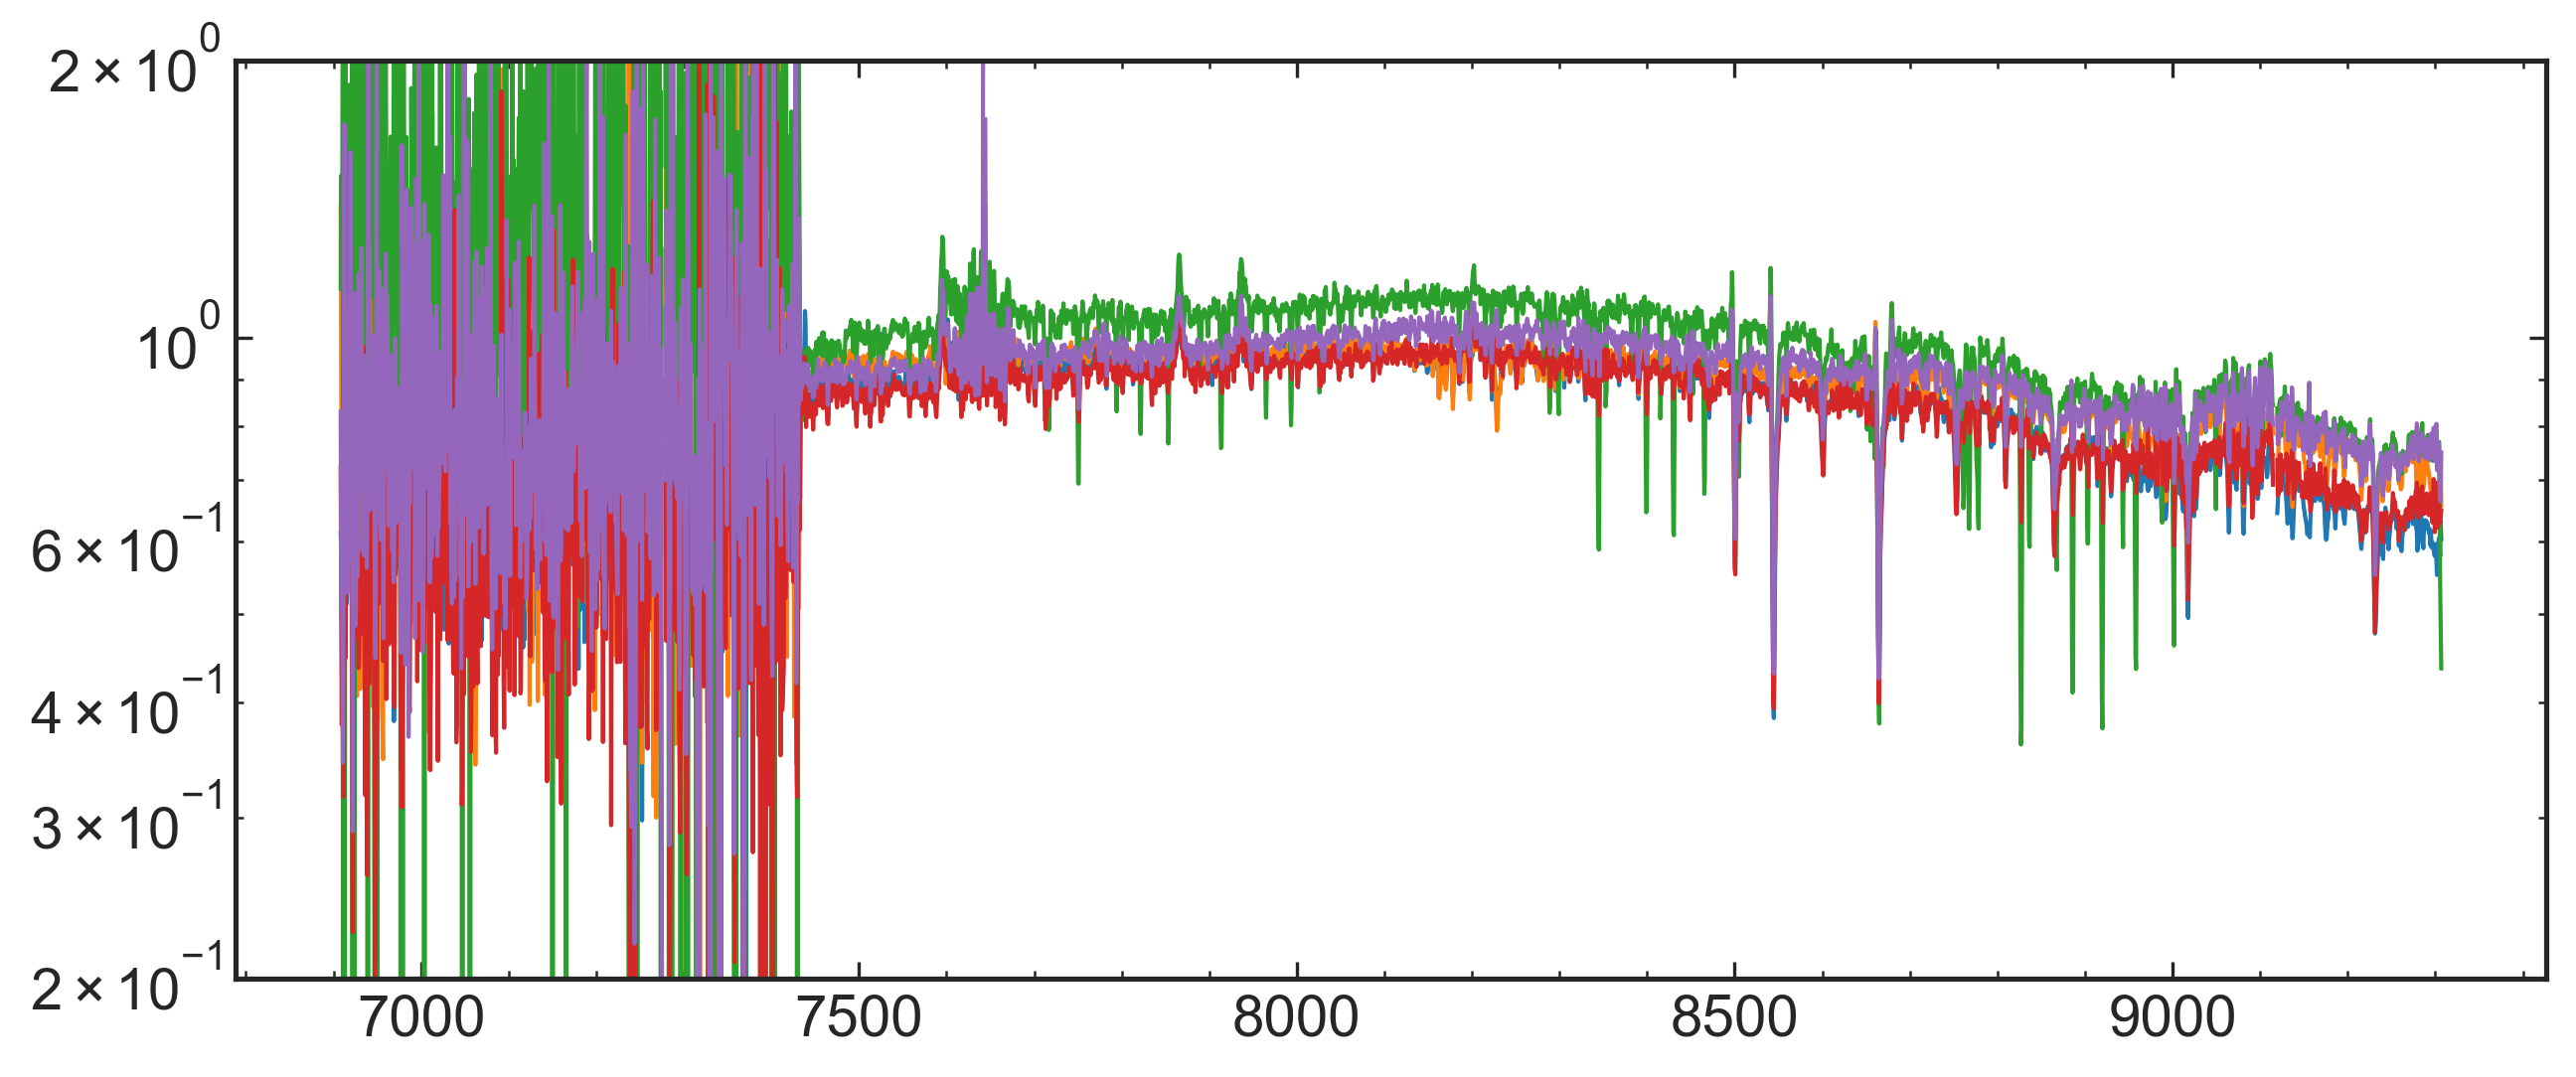

In [41]:
fig1, ax1 = plt.subplots(1,1, figsize=(10,4), dpi=300)

spec2D_fixed_all = sorted(os.listdir(save_fluxcalib_dir))

data_wave, data_flux, ra, dec, alpha[i], beta[i] = load_star_spec(star_id, tell_corr=True, mask_pix=100)

fluxcal.get_star_mags(ra, dec, verbose=False)
calibration = fluxcal.flux_calibration(data_flux, data_wave)
trueflux    = data_flux * calibration
# plt.semilogy(data_wave, trueflux, lw=2, c='k')

for ss, spec2D_file in enumerate(spec2D_fixed_all):
    
    night  = spec2D_file.split('_')[0]
    print(night)
    
    spec2D_file_path = save_fluxcalib_dir + spec2D_file
    spec2D_hdu = fits.open(spec2D_file_path)
    
    # Extract star in 2 PSF aperture
    star_id = 19
    spec2D = spec2D_hdu[star_id + 1].data * 1e-19
    psf  = np.nansum(spec2D, axis=1)
    psf /= psf.max()
    
    # Fit with Gaussian
    x = np.arange(len(psf))
    y = psf

    mod  = GaussianModel()
    pars = mod.guess(y, x=x)
    out  = mod.fit(y, pars, x=x)
    PSF_FWHM = out.values['fwhm'] # pixels

    FWHM = 2*PSF_FWHM
    spec1D_sum_psfFWHM = np.nansum(spec2D[int(np.argmax(psf)-FWHM/2):int(np.argmax(psf)+FWHM/2 + 1)], axis=0)
    plt.semilogy(data_wave, trueflux/spec1D_sum_psfFWHM, lw=1, label=night)
    

# legend1 = ax1.legend(handles=[star19, star20], loc=(0.2, 0.75))
# ax1.add_artist(legend1)
# ax1.legend(frameon=True, framealpha=1)

# ax1.set_ylabel("SDSS flux / input")
# ax1.set_xlabel("Wavelenth [$\mathrm{\AA}$]")

# ax1.set_xlim(data_wave.min(), data_wave.max())
# ax1.set_ylim(2e-16, 2e-15)
ax1.set_ylim(2e-1, 2)

# fig1.savefig('2019A_calib_flux_tellcorr.pdf', bbox_inches='tight')

{'sigma': 1.7648292515750317,
 'center': 13.280629256927968,
 'amplitude': 4.3821560647912685,
 'fwhm': 4.155855218193916,
 'height': 0.9905929527667124}